# Regression with Fourier Features - Part 3

Apply the space-time Fourier embedded net on the original linear oscillator problem.

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
from collections import OrderedDict

# set random seeds
np.random.seed(10)
torch.manual_seed(10);
torch.set_default_dtype(torch.float64)

import numpy as np    
import matplotlib.pyplot as plt

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

In [2]:
# define vanilla deep neural net
class DNN(torch.nn.Module):
    def __init__(
        self, layers, 
        activation=torch.nn.ReLU, 
        last_layer_activation=None,
        initialization=None
    ):
        """ 
            Custom initialization of neural network layers with the option 
            of changing the output layer's activation function.
            
            The deep net is in space-time.
        """
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        if last_layer_activation is not None:
            layer_list.append(
            ('activation_%d' % (self.depth - 1), last_layer_activation())
        )

        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
        # custom initialization modes
        self.initialize(mode=initialization)
        
        
    def forward(self, x):
        return self.layers(x)
    
    def initialize(self, mode):
        if mode == None:
            return
        else:
            for layer in self.layers:
                if isinstance(layer, torch.nn.Linear):
                    # initialize depending on mode
                    if mode == "xavier":
                        torch.nn.init.xavier_uniform_(layer.weight)
                    elif mode == "kaiming":
                        torch.nn.init.kaiming_uniform_(layer.weight)
                    elif mode == "normal":
                        torch.nn.init.normal_(layer.weight)
                    elif mode == "uniform":
                        torch.nn.init.uniform_(layer.weight)
                    elif mode == "ones":
                        torch.nn.init.ones_(layer.weight)
                    else:
                        raise NotImplementedError()
            return
        
class FourierEmbeddedDNN(torch.nn.Module):
    def __init__(self, 
                 layers, 
                 activation=torch.nn.Tanh, 
                 last_layer_activation=None, 
                 initialization=None,
                 m=1,
                 freq_stds=None):
        super(FourierEmbeddedDNN, self).__init__()
        # fourier embedding is applied prior to passing into neural net, 
        # need to make sure dimensions match
        assert layers[0] == 2*m
        # build main DNN
        self.layer_spec = layers
        self.layers = self.build_nn(
            layers, activation, last_layer_activation, initialization
        )
        # build fourier feature embedding
        self.fourier_embedding = self.build_embedding(m, freq_stds)
        
        # build final aggregator to combine outputs of different scale fourier embeddings
        self.build_aggregator()
    
    def build_nn(self, layers, activation, last_layer_activation, initialization):
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        if last_layer_activation is not None:
            layer_list.append(
            ('activation_%d' % (self.depth - 1), last_layer_activation())
        )

        layerDict = OrderedDict(layer_list)
        return torch.nn.Sequential(layerDict)
    
    def build_embedding(self, num_freqs, freq_stds):
        # number of feature embeddings correspond to length of standard 
        # deviations specified. If `None`, by default uses only 1 embedding
        # standard Gaussian.
        if freq_stds:
            self.num_embeddings = len(freq_stds)
        else:
            self.num_embeddings = 1
            freq_stds = [1.0]
        # draw frequency matrix
        freq_matrix = [torch.randn(num_freqs, requires_grad=False) for _ in range(self.num_embeddings)]
        for i in range(self.num_embeddings):
            # scale by frequency standard deviation
            freq_matrix[i] = torch.tensor(freq_stds[i])*freq_matrix[i]
        return freq_matrix
    
    def build_aggregator(self):
        # number of fourier embeddings
        k = self.num_embeddings
        # size of hidden layer final outputs
        num_out = self.layer_spec[-1]
        # create trainable aggregating weights for each embedding (simple linear aggregation
        # , may also consider computing another nonlinear activation for each embedding, then 
        # summing all outputs).
        self.aggregator = torch.nn.Linear(num_out*k, 1)
        
    def fourier_lifting(self, x, freq):
        # input x has size (N x 1), output has size (N x 2*m) where m is number of Fourier bases
        
        # has size (N x m)
        x = freq * x
        # lift to sin and cos space
        x = torch.concat(
            [
                torch.cos(2*torch.pi*x), 
                torch.sin(2*torch.pi*x)
            ], dim=1
        )
        return x
    
    def forward(self, x):
        # inputs x has size (N x 1)
        # create Fourier features
        lifted = []
        for i in range(self.num_embeddings):
            lifted.append(self.fourier_lifting(x, self.fourier_embedding[i]))
        # lifted is a length-k list of (N x 2*m) tensors of lifted features according to 
        # k different scales.
        
        # now pass each (N x 2*m) features into the hidden layers
        for i in range(self.num_embeddings):
            lifted[i] = self.layers(lifted[i])
        
        # lifted is a length-k list of (N x num_out) tensor of transformed fourier features
        # now concatenate into (N x num_out*k) and pass into aggregator to obtain (N x 1) prediction
        lifted = torch.concat(lifted, dim=1)
        # final aggregation
        lifted = self.aggregator(lifted)
        return lifted

In [3]:
class FourierEmbeddedDNN2d(torch.nn.Module):
    """ 
        A deep neural network suitable for learning space-time functions by stacking
        two separate Fourier embedded nets together and combining the results.

        The spatial and temporal Fourier mappings share the same DNN for hidden transformations.
    """
    def __init__(self, layers, activation=torch.nn.Tanh, 
                 last_layer_activation=None, initialization=None, 
                 m=1, freq_stds=None):
        super(FourierEmbeddedDNN2d, self).__init__()
        # fourier embedding is applied prior to passing into neural net, 
        # need to make sure dimensions match
        assert layers[0] == 2*m
        if freq_stds is not None:
            assert freq_stds.shape[1] == 2, "Specify both space and time frequency scales. "
        else:
            freq_stds = np.ones([1, 2])
        
        # build main DNN
        self.layer_spec = layers
        self.layers = self.build_nn(
            layers, activation, last_layer_activation, initialization
        )
        # build fourier feature embedding
        self.fourier_embedding_time, self.fourier_embedding_space = self.build_embedding(m, freq_stds)
        
        # build final aggregator to combine outputs of different scale fourier embeddings
        self.build_aggregator()
    
    def build_nn(self, layers, activation, last_layer_activation, initialization):
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        if last_layer_activation is not None:
            layer_list.append(
            ('activation_%d' % (self.depth - 1), last_layer_activation())
        )

        layerDict = OrderedDict(layer_list)
        return torch.nn.Sequential(layerDict)

    def build_embedding(self, num_freqs, freq_stds):
        # number of feature embeddings correspond to length of standard 
        # deviations specified. If `None`, by default uses only 1 embedding
        # standard Gaussian.
        self.num_embeddings = freq_stds.shape[0]
        # time domain scales
        freq_stds_t = freq_stds[:, 0].flatten()
        # spatial domain scales
        freq_stds_x = freq_stds[:, 1].flatten()
        
        # draw frequency matrix (time)
        freq_matrix_t = [torch.randn(num_freqs, requires_grad=False) for _ in range(self.num_embeddings)]
        # draw frequency matrix (space)
        freq_matrix_x = [torch.randn(num_freqs, requires_grad=False) for _ in range(self.num_embeddings)]
        
        for i in range(self.num_embeddings):
            # scale by frequency standard deviation
            freq_matrix_t[i] = torch.tensor(freq_stds_t[i])*freq_matrix_t[i]
            freq_matrix_x[i] = torch.tensor(freq_stds_x[i])*freq_matrix_x[i]
        return freq_matrix_t, freq_matrix_x

    def fourier_lifting(self, x, freq):
        # input x has size (N x 1), output has size (N x 2*m) where m is number of Fourier bases
        
        # has size (N x m)
        x = freq * x
        # lift to sin and cos space
        x = torch.concat(
            [
                torch.cos(2*torch.pi*x), 
                torch.sin(2*torch.pi*x)
            ], dim=1
        )
        return x
    
    def build_aggregator(self):
        # number of fourier embeddings
        k = self.num_embeddings
        # size of hidden layer final outputs
        num_out = self.layer_spec[-1]
        # create trainable aggregating weights for each embedding (simple linear aggregation
        # , may also consider computing another nonlinear activation for each embedding, then 
        # summing all outputs).
        self.aggregator = torch.nn.Linear(num_out*k, 1)
    
    def forward(self, inputs):
        # inputs has size (N x 2)
        # create Fourier features for t
        t = inputs[:, 0][:, None]
        x = inputs[:, 1][:, None]
        
        lifted_t, lifted_x = [], []
        for i in range(self.num_embeddings):
            lifted_t.append(self.fourier_lifting(t, self.fourier_embedding_time[i]))
            lifted_x.append(self.fourier_lifting(x, self.fourier_embedding_space[i]))
            
        # lifted is a length-k list of (N x 2*m) tensors of lifted features according to 
        # k different scales.
        
        # now pass each (N x 2*m) features into the hidden layers
        for i in range(self.num_embeddings):
            lifted_t[i] = self.layers(lifted_t[i])
            lifted_x[i] = self.layers(lifted_x[i])
        
        
        # lifted is a length-k list of (N x num_out) tensor of transformed fourier features
        # now concatenate into (N x num_out*k) and pass into aggregator to obtain (N x 1) prediction
        lifted_t = torch.concat(lifted_t, dim=1)
        lifted_x = torch.concat(lifted_x, dim=1)
        
        # elementwise multiplication
        lifted = lifted_t * lifted_x
        # final aggregation
        lifted = self.aggregator(lifted)
        return lifted
    
# helper
def cartesian_data(x, y):
    """
        Given two 1d arrays of points, return their Carteisan product
        as a list, assuming column-major flattening.
    """
    nx, ny = len(x), len(y)
    y_mesh, x_mesh = torch.meshgrid(y, x, indexing=None)
    x_mesh_flat = x_mesh.ravel().reshape(-1, 1)
    y_mesh_flat = y_mesh.ravel().reshape(-1, 1)
    res = torch.cat(
        [x_mesh_flat, y_mesh_flat], dim=1
    )
    assert len(res) == nx * ny
    return res

In [4]:
# modify dataset
full_data_path = "../data/LinearOscillator/OU_Noise_energy.mat"
data = scipy.io.loadmat(full_data_path)
# subsample factor
space_factor = 5
time_factor = 5
new_pmc = (data["v_density"].T)[0:-1:time_factor, 0:-1:space_factor]
new_xgrid = data["xi"][:, 0:-1:space_factor]
new_tgrid = data["tspan"][:, 0:-1:time_factor]
# save new data
new_data_path = "../data/LinearOscillator/OU_Noise_energy_subsample{}.mat".format(int(space_factor*time_factor))
scipy.io.savemat(
    new_data_path, {"pmc": new_pmc, "xgrid": new_xgrid, "tgrid": new_tgrid}
)
# test saved data
new_data_path = "../data/LinearOscillator/OU_Noise_energy_subsample25.mat"
data = scipy.io.loadmat(new_data_path)
print(data["pmc"].shape, data["xgrid"].shape, data["tgrid"].shape)
# set random seeds
np.random.seed(10)
torch.manual_seed(10);

data_path = "../data/LinearOscillator/OU_Noise_energy_subsample25.mat"
data = scipy.io.loadmat(data_path)

/Users/honglizhaobob/opt/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


(1000, 1000) (1, 1000) (1, 1000)


In [5]:
X = cartesian_data(torch.tensor(new_tgrid[0].flatten()), torch.tensor(new_xgrid.flatten()))
y = torch.tensor(new_pmc).T.flatten().reshape(-1, 1)
# define training function
def train(inputs, outputs, model, optim, scheduler, batch_size, epochs, shuffle=True):
    X, y = inputs, outputs
    nx = X.shape[0]
    num_batches = int(nx/batch_size)
    for i in range(epochs):
        print("============================================================\n")
        print("Epoch = {}\n".format(i+1));
        print("============================================================\n")
        model.train()
        if shuffle:
            tmp = np.random.permutation(nx)
            X, y = X[tmp, :].data.clone(), y[tmp, :].data.clone()
        for idx in range(num_batches):
            if idx % 100 == 0:
                print("| => | Batch {} |\n".format(idx+1))
        # closure definition
            def closure():
                optim.zero_grad()
                start_idx = idx*batch_size
                end_idx = (idx+1)*batch_size
                if idx + 1 == num_batches:
                    # if last batch
                    end_idx = -1
                Xb, yb = X[start_idx:end_idx, :].data.clone(), y[start_idx:end_idx, :].data.clone()

                # require gradients
                Xb.requires_grad = True
                # make a prediction on the batch
                y_pred = model.forward(Xb)
                # compute L^2 loss
                loss = torch.mean((y_pred - yb)**2)
                # backpropagate
                loss.backward()
                if idx % 100 == 0:
                    print("==> Batch {} loss = {}".format(idx, loss.item()))
                return loss
            optim.step(closure=closure)
        if scheduler:
            # step scheduler after epoch if there is one
            scheduler.step()
            print("---------- \n")
            print("++ Learning rate reduced, now at = {}".format(scheduler.get_last_lr()[0]))

/Users/honglizhaobob/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# testing Fourier embedded net in 2d
nn_fourier2d = FourierEmbeddedDNN2d(
    layers=[40, 128, 128, 128, 1],
    m=20, 
    freq_stds=np.array([[1.,2.,10.,20.,100.], [1.,2.,10.,20.,100.]]).T
)
optim = torch.optim.Adam(
    nn_fourier2d.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_fourier2d, optim, scheduler, 2**12, 50, shuffle=True)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 0.001138279138701199
| => | Batch 101 |

==> Batch 100 loss = 3.7454255658454435e-06
| => | Batch 201 |

==> Batch 200 loss = 2.6799766812487297e-06
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 2.6774457860591782e-06
| => | Batch 101 |

==> Batch 100 loss = 1.8571954020556704e-06
| => | Batch 201 |

==> Batch 200 loss = 2.9517191435465477e-06
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 2.401034934061155e-06
| => | Batch 101 |

==> Batch 100 loss = 2.897535656921271e-06
| => | Batch 201 |

==> Batch 200 loss = 2.7518109540887333e-06
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 2.4110320024138943e-06
| => | Batch 101 |

==> Batch 100 loss = 1.7000886393870017e-06
| => | Batch 201 |

==> Batch 200 loss = 2.471781534950747e-06
-----

==> Batch 0 loss = 9.642378235876923e-07
| => | Batch 101 |

==> Batch 100 loss = 1.2596340991066998e-06
| => | Batch 201 |

==> Batch 200 loss = 1.08290196866084e-06
---------- 

++ Learning rate reduced, now at = 0.00798241846768585

Epoch = 23


| => | Batch 1 |

==> Batch 0 loss = 1.1960414152381779e-06
| => | Batch 101 |

==> Batch 100 loss = 1.1005260024317373e-06
| => | Batch 201 |

==> Batch 200 loss = 6.664729690557584e-07
---------- 

++ Learning rate reduced, now at = 0.007981620225839082

Epoch = 24


| => | Batch 1 |

==> Batch 0 loss = 8.309967719284402e-07
| => | Batch 101 |

==> Batch 100 loss = 1.0729614753536355e-06
| => | Batch 201 |

==> Batch 200 loss = 9.470345750777385e-07
---------- 

++ Learning rate reduced, now at = 0.007980822063816497

Epoch = 25


| => | Batch 1 |

==> Batch 0 loss = 6.265683032743988e-07
| => | Batch 101 |

==> Batch 100 loss = 7.665081675237523e-07
| => | Batch 201 |

==> Batch 200 loss = 8.874479323418739e-07
---------- 

++ Learning ra

| => | Batch 101 |

==> Batch 100 loss = 3.7029858182040574e-07
| => | Batch 201 |

==> Batch 200 loss = 3.940345472757975e-07
---------- 

++ Learning rate reduced, now at = 0.007965672141370653

Epoch = 44


| => | Batch 1 |

==> Batch 0 loss = 3.726468796101935e-07
| => | Batch 101 |

==> Batch 100 loss = 4.4919615762879174e-07
| => | Batch 201 |

==> Batch 200 loss = 3.449624541035282e-07
---------- 

++ Learning rate reduced, now at = 0.007964875574156515

Epoch = 45


| => | Batch 1 |

==> Batch 0 loss = 4.135636885271273e-07
| => | Batch 101 |

==> Batch 100 loss = 5.824323676046979e-07
| => | Batch 201 |

==> Batch 200 loss = 5.15724686609621e-07
---------- 

++ Learning rate reduced, now at = 0.0079640790865991

Epoch = 46


| => | Batch 1 |

==> Batch 0 loss = 3.409354857155012e-07
| => | Batch 101 |

==> Batch 100 loss = 3.1981398149688323e-07
| => | Batch 201 |

==> Batch 200 loss = 5.792363596824148e-07
---------- 

++ Learning rate reduced, now at = 0.007963282678690441



In [13]:
p_pred = nn_fourier2d(X).reshape([len(new_xgrid[0]), len(new_tgrid[0])]).detach().numpy().T

In [29]:
p_exact = data["pmc"]

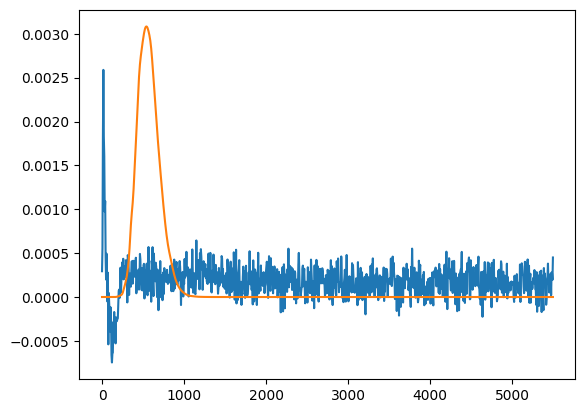

In [47]:
idx = 100
plt.figure(1);
plt.plot(data["xgrid"].flatten(), p_pred[idx, :]);
plt.plot(data["xgrid"].flatten(), p_exact[idx, :]);